In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from datetime import datetime

dataset_path = '../data/raw/export_df.parquet'

In [2]:
df = pd.read_parquet(dataset_path)
df.head()

df_copy = df.copy()

#### Arrival Date Feature Engineering

In [12]:
def process_arrival_date(df, years=None):
    df['datum_dolaska'] = pd.to_datetime(df['datum_dolaska'], errors='coerce')

    df['year'] = df['datum_dolaska'].dt.year
    df['month'] = df['datum_dolaska'].dt.month
    df['week'] = df['datum_dolaska'].dt.isocalendar().week.astype(float)
    df['day'] = df['datum_dolaska'].dt.day
    df['dayofweek'] = df['datum_dolaska'].dt.dayofweek
    df['quarter'] = df['datum_dolaska'].dt.quarter
    df['dayofyear'] = df['datum_dolaska'].dt.dayofyear

    if years is not None:
        if not isinstance(years, list):
            years = [years]  
        df = df[df['year'].isin(years)]

    return df


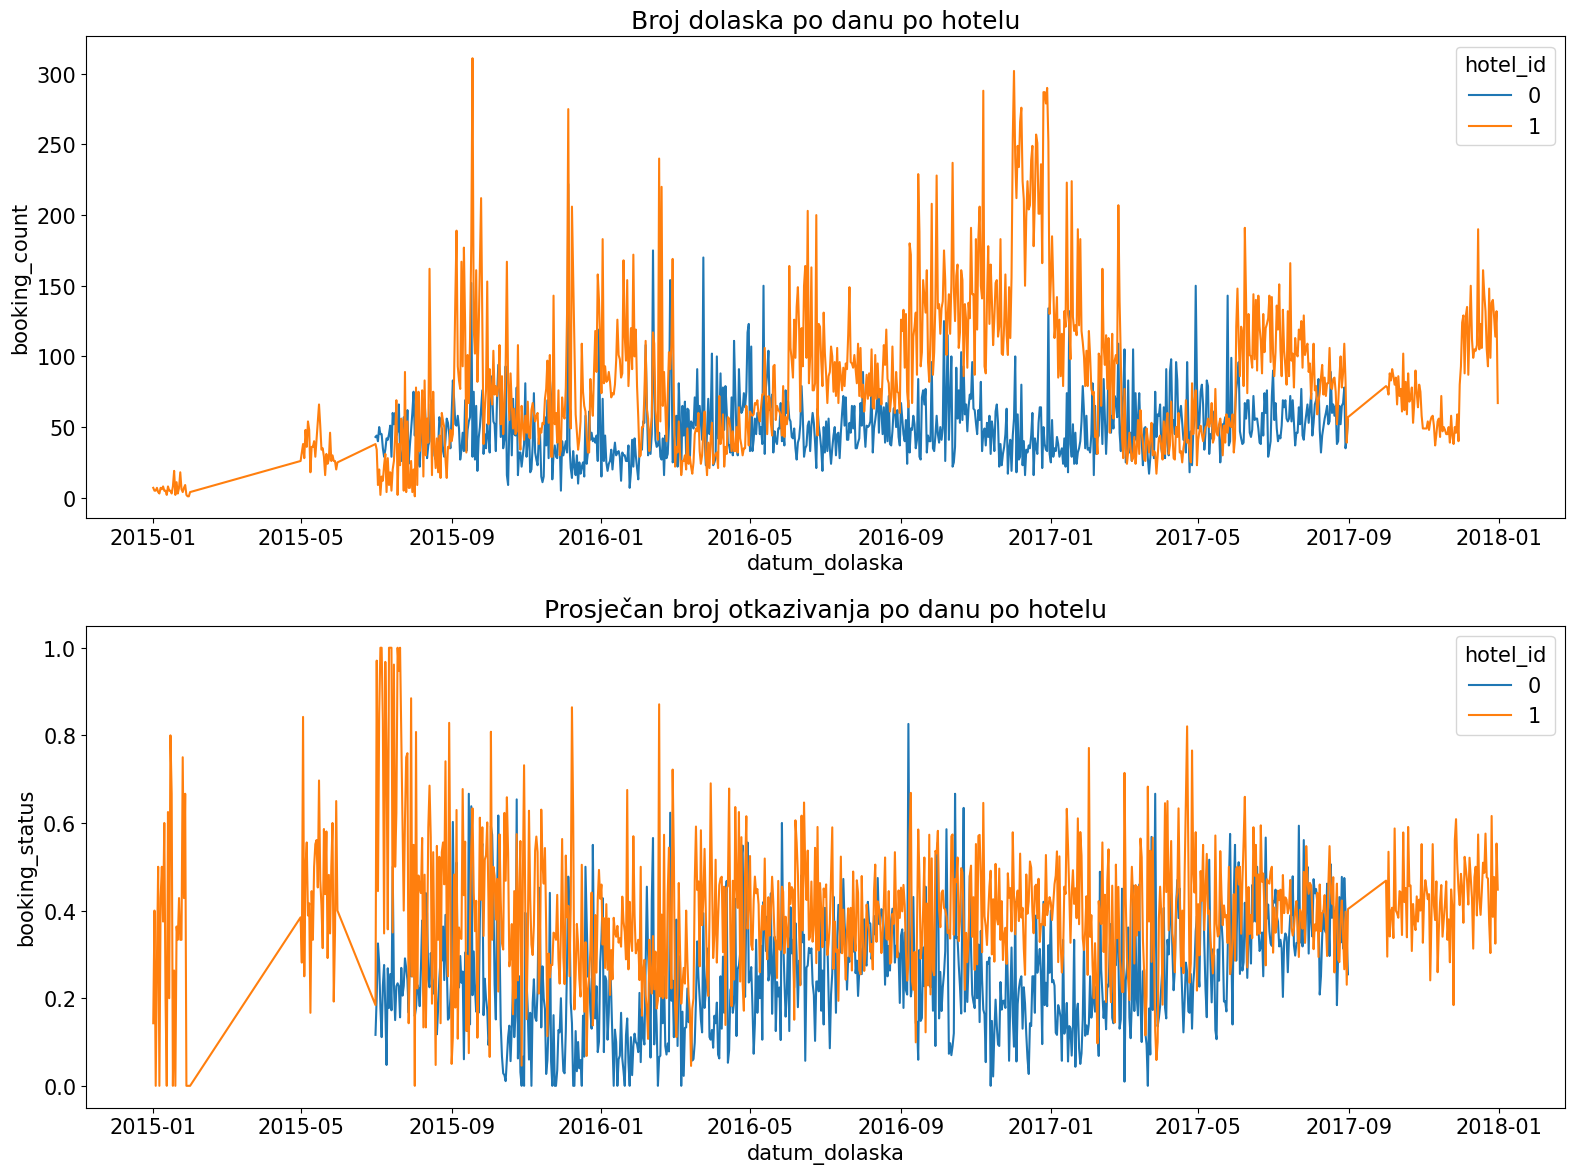

In [19]:
df = process_arrival_date(df_copy)

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu')

plt.tight_layout()
plt.show()

### Same visuals but for a 2015


C:\Temp\ipykernel_29188\1708044265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)


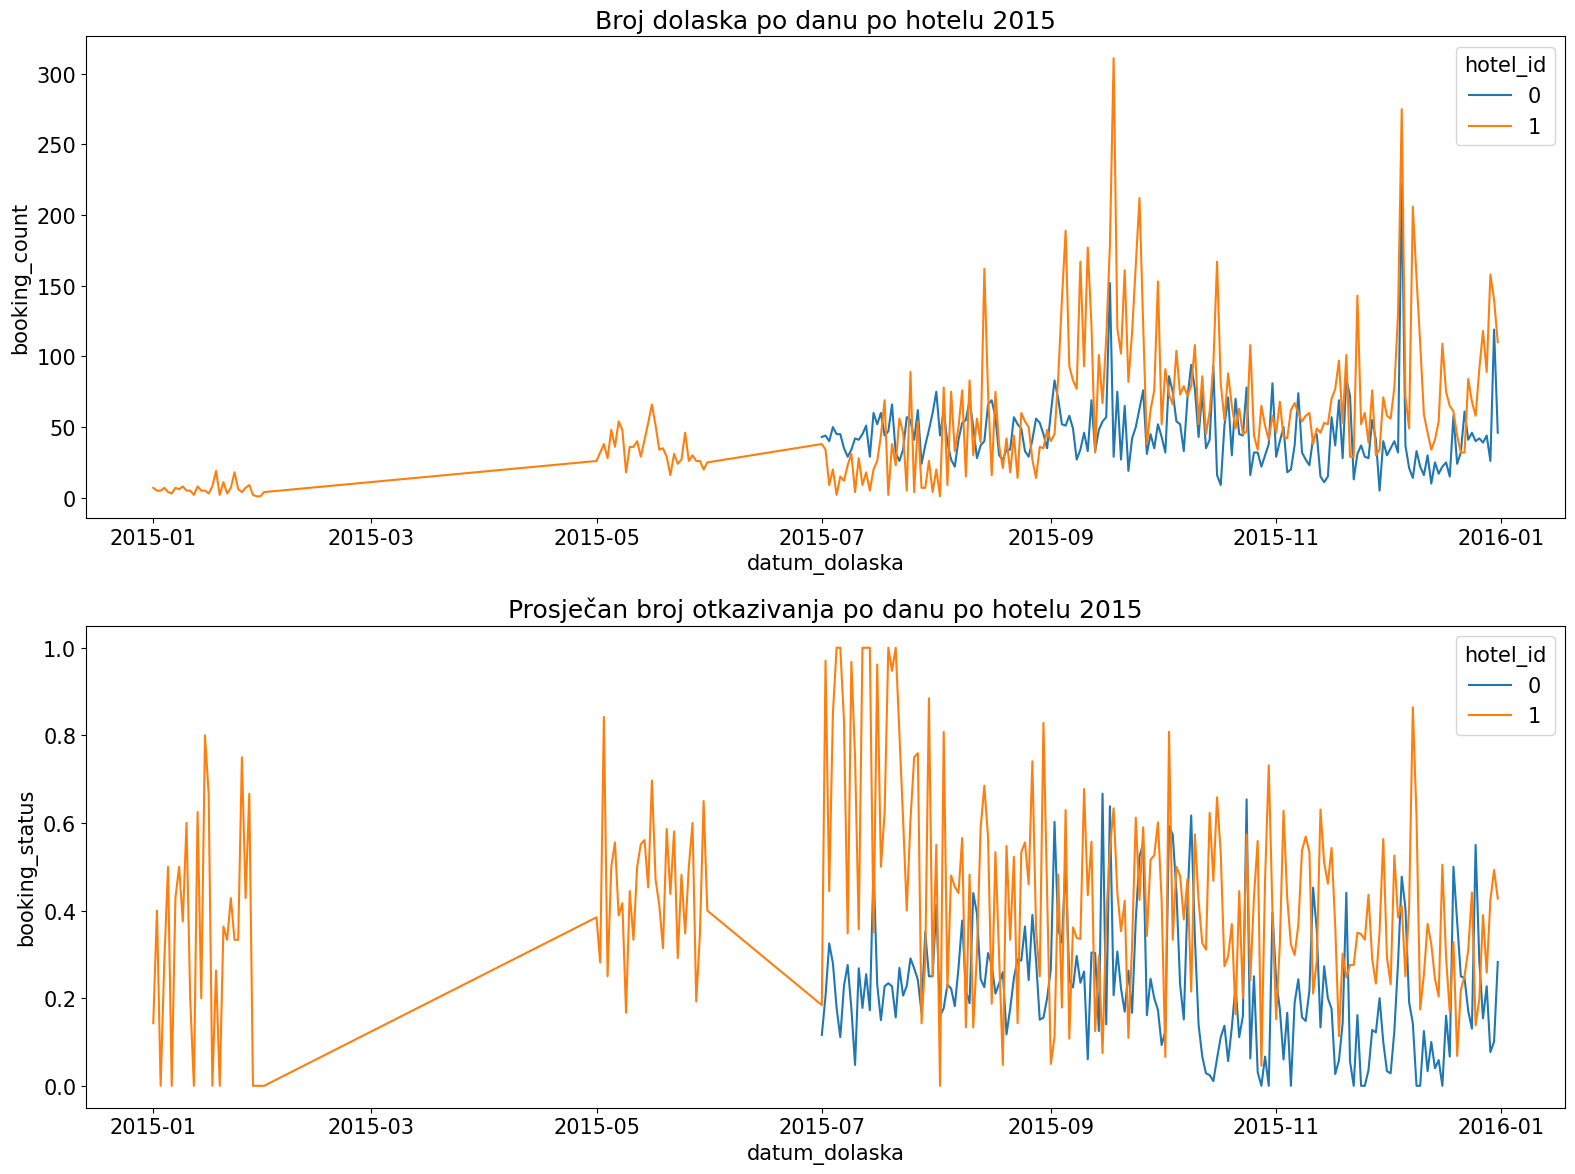

In [20]:
df = process_arrival_date(df_copy,years=[2015])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2015')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2015')

plt.tight_layout()
plt.show()

### Same visuals but for a 2016


C:\Temp\ipykernel_29188\4000592822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)


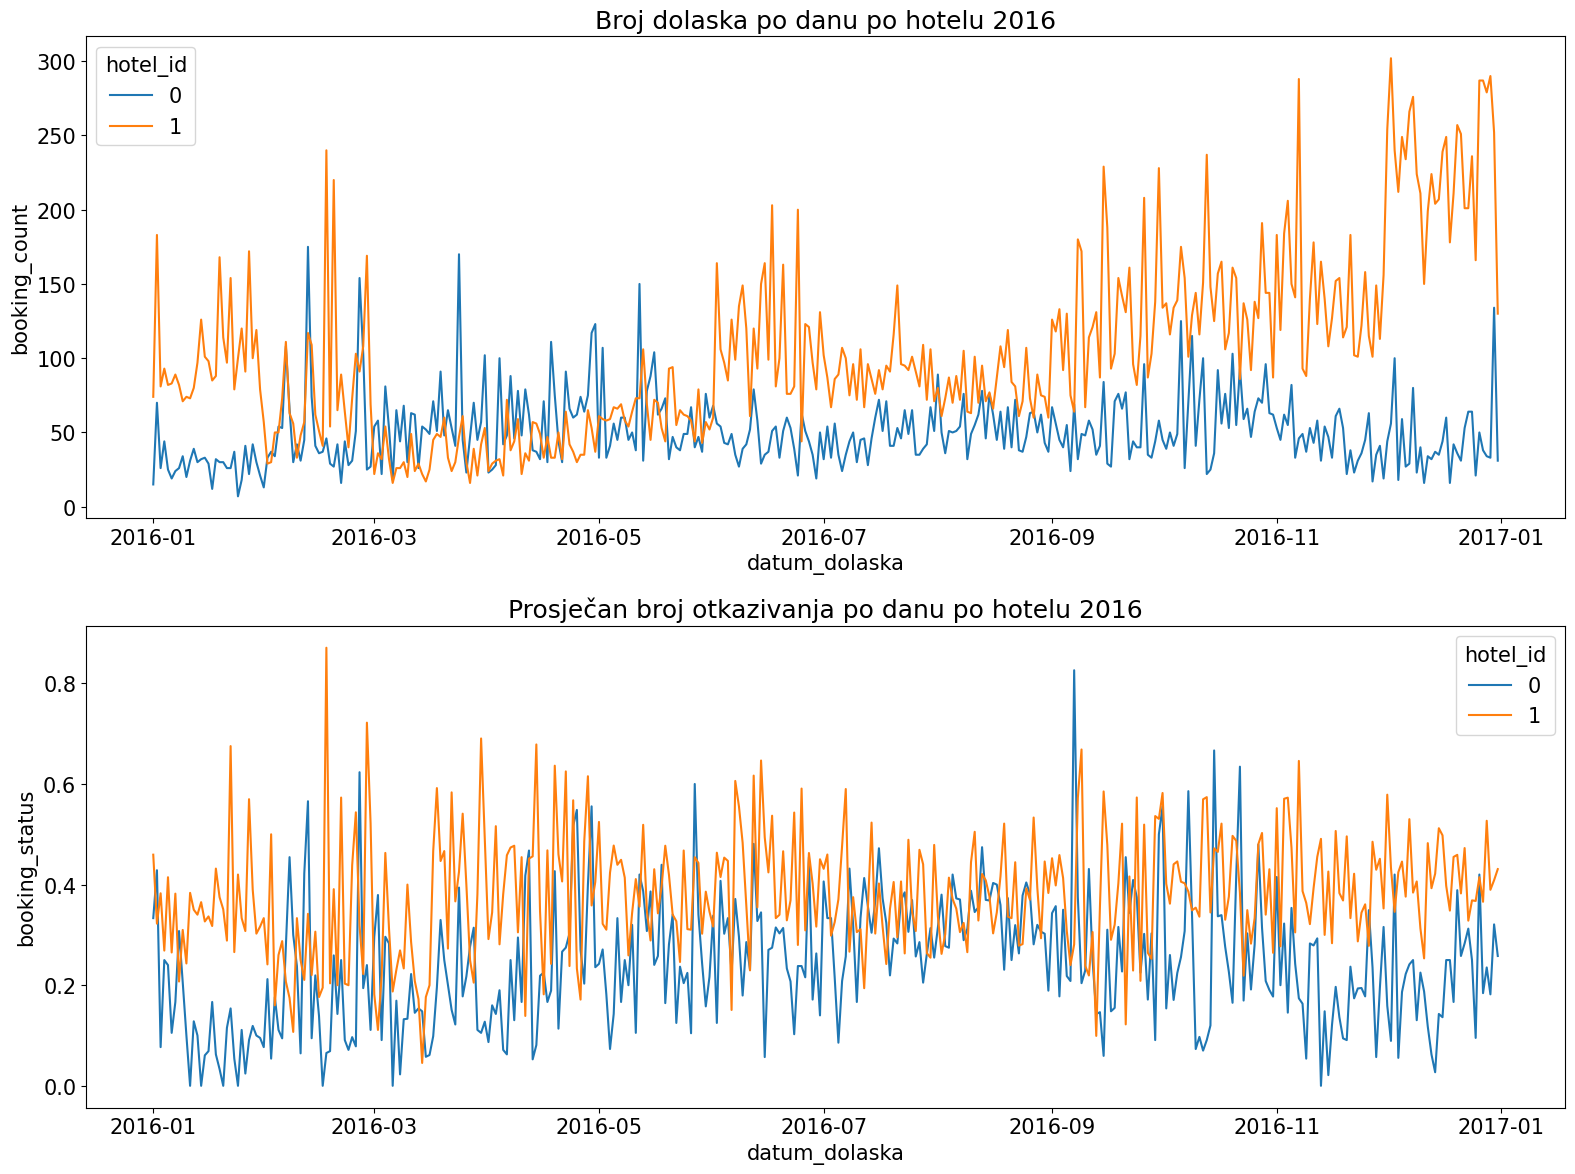

In [21]:
df = process_arrival_date(df_copy,years=[2016])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2016')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2016')

plt.tight_layout()
plt.show()

### Same visuals but for a 2017


C:\Temp\ipykernel_29188\3981425558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)


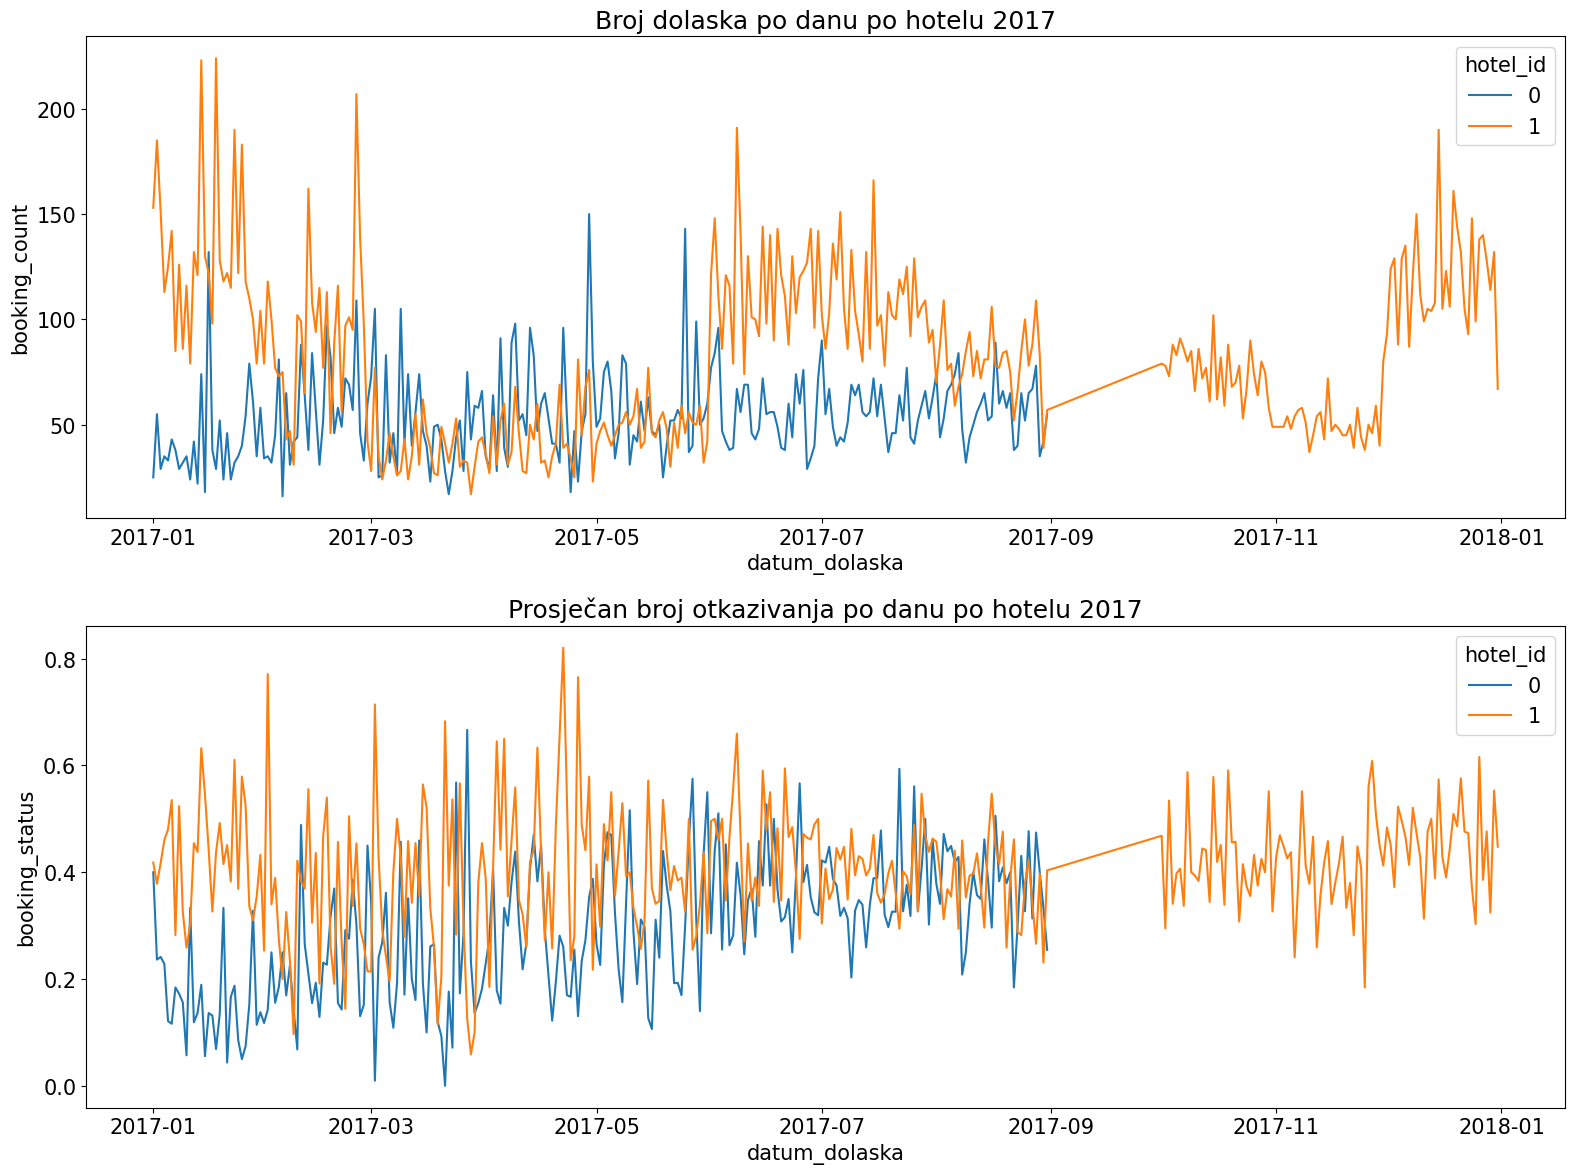

In [22]:
df = process_arrival_date(df_copy,years=[2017])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2017')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2017')

plt.tight_layout()
plt.show()

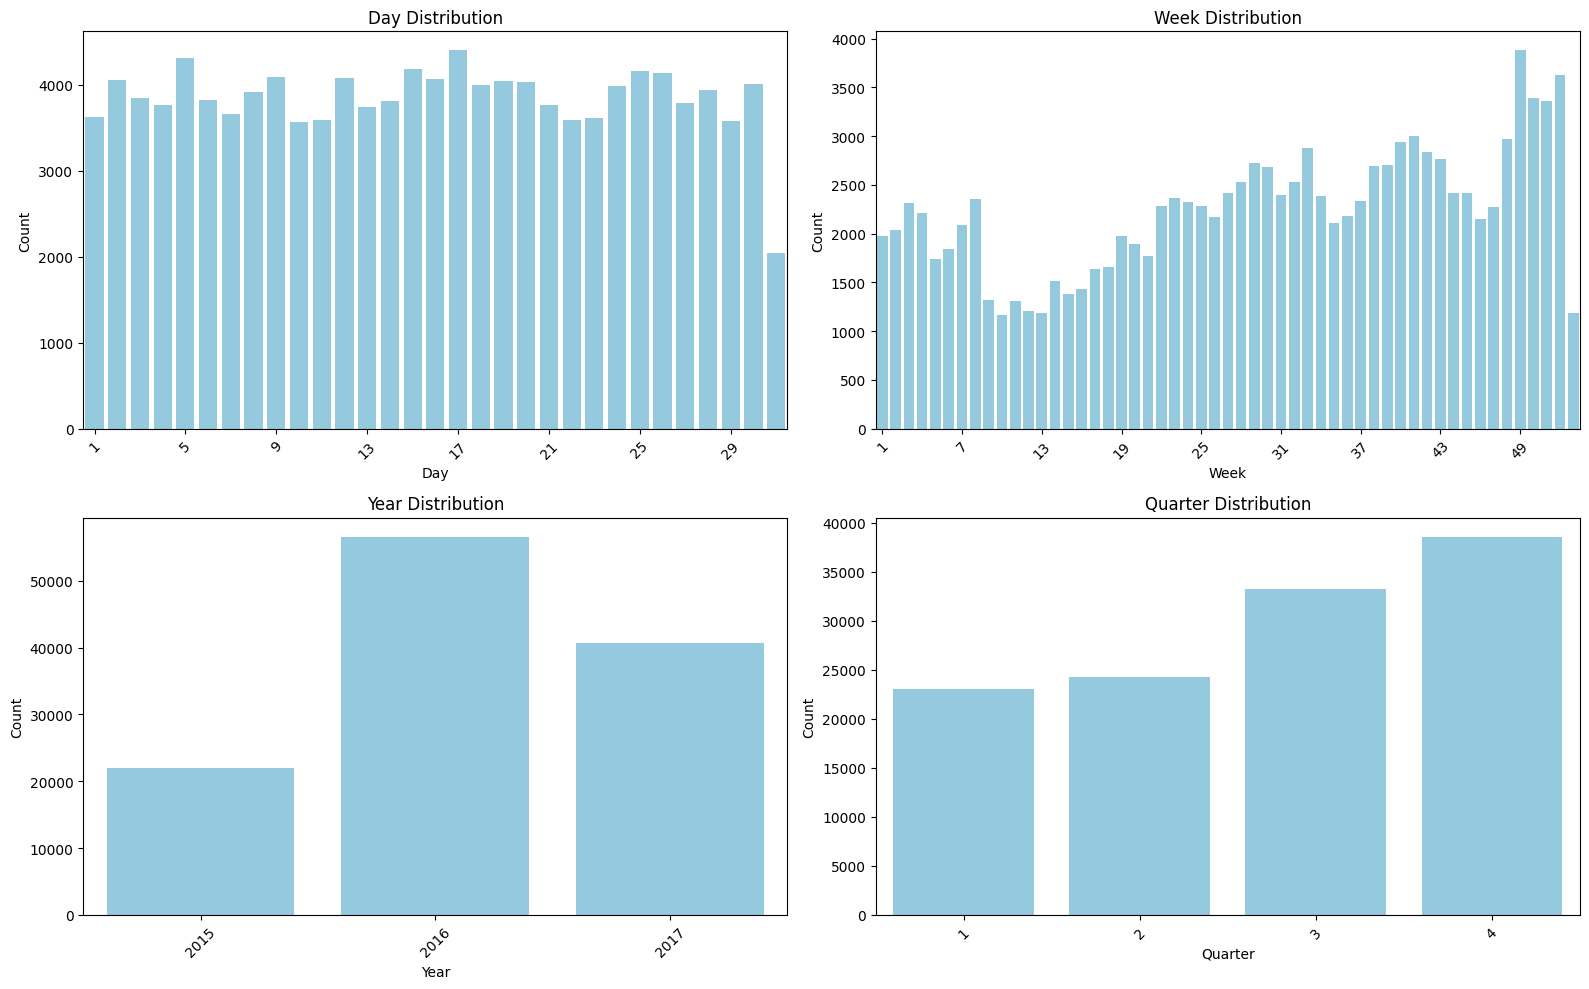

In [27]:
feature_dates = ['day', 'week', 'year', 'quarter']

n_cols = 2
n_rows = math.ceil(len(feature_dates) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
ax = ax.flatten()

for i, feature in enumerate(feature_dates):
    sns.countplot(data=df, x=feature, ax=ax[i], color='skyblue')
    ax[i].set_title(f'{feature.capitalize()} Distribution')
    ax[i].set_xlabel(feature.capitalize())
    ax[i].set_ylabel('Count')

    xticks = ax[i].get_xticklabels()
    xticks = [int(float(x.get_text())) for x in xticks if x.get_text()]
    ax[i].set_xticklabels(xticks, rotation=45)

    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [33]:
df['duljina_boravka'] = df['datum_odjave'] - df['datum_dolaska']
df['duljina_boravka'] = df['duljina_boravka'].dt.days

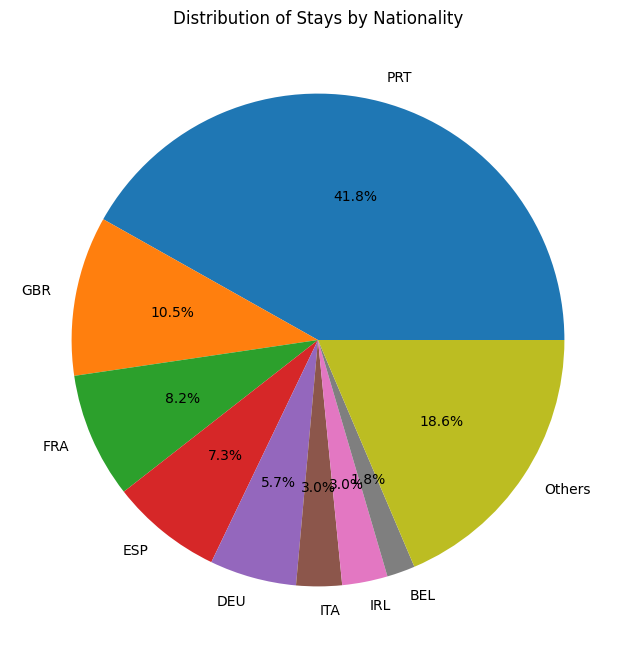

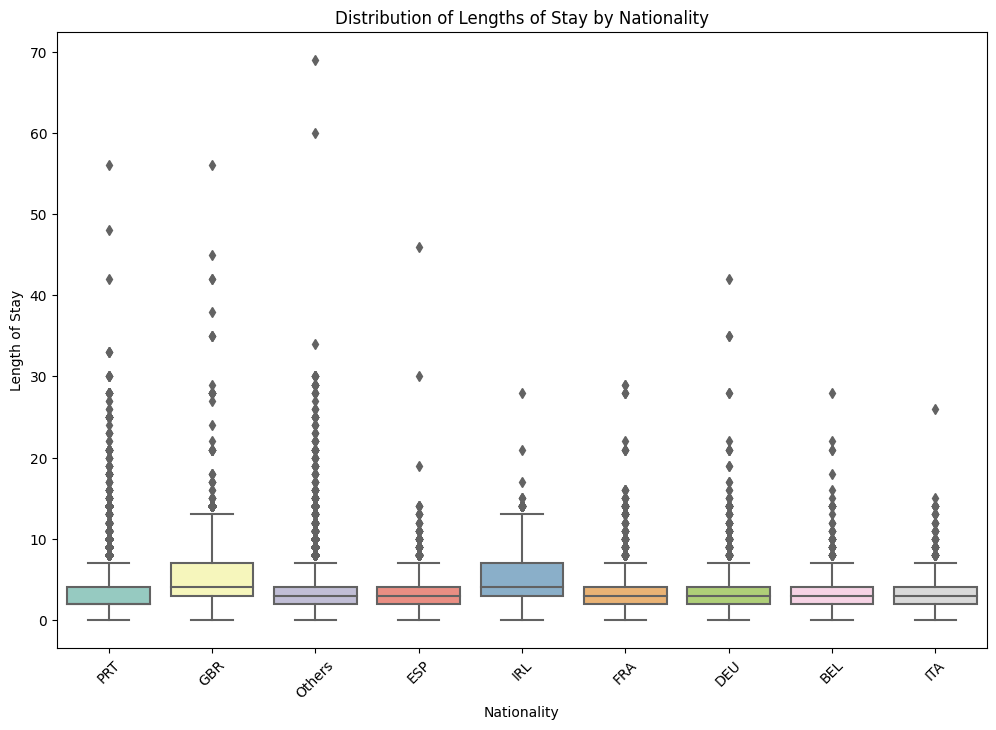

In [35]:
nationality_counts = df['zemlja_gosta'].value_counts()

top_nationalities = nationality_counts.head(8)
top_nationalities['Others'] = nationality_counts[8:].sum()

plt.figure(figsize=(8, 8))
top_nationalities.plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Stays by Nationality')
plt.ylabel('') 


df['nationality_category'] = df['zemlja_gosta'].apply(lambda x: x if x in nationality_counts.head(8).index.tolist() else 'Others')

plt.figure(figsize=(12, 8))
sns.boxplot(x='nationality_category', y='duljina_boravka', data=df, palette='Set3')
plt.title('Distribution of Lengths of Stay by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Length of Stay')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()
